# Housing Price Simulation.

A notebook by *List your names here*.

Then, add alternating code cells and description/markdown cells,
between this top cell and the final "Running DocTest tests" section,
to answer all the elements of the final project programming assignment.

The answer to each part must be clearly identified with,
the text "Step 1" for Step 1, "Step 2" for Step 2, etc.
As noted in the assignment, you may do some of the work in copies of this project
for different sub-experiments,
rather than just putting it all in this notebook,
if you like.

In [45]:
import numpy as np
import doctest
import matplotlib.pyplot as plt
import pandas as pd

## Data Generation

Income: [  80.05490778   80.06374134   80.10256174 ... 4347.84052999 6847.91304905
 9273.91765711]
Housing Distance: [5.88650038e-05 8.01856975e-05 9.00192972e-05 ... 5.66290933e-01
 5.94458671e-01 6.50297156e-01]


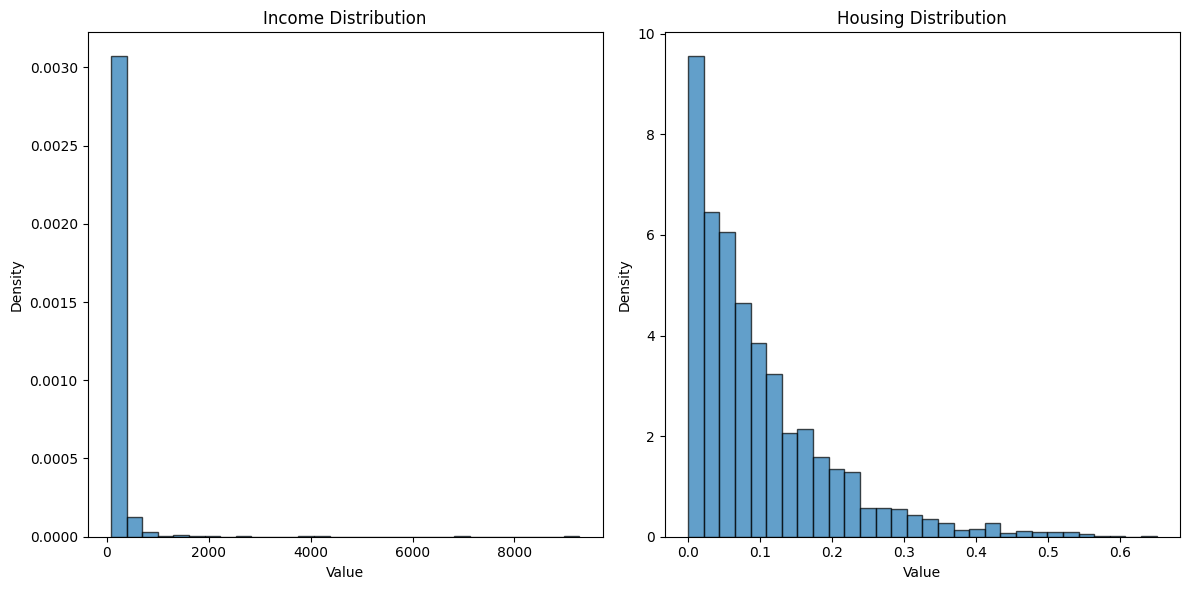

Income: [  80.03506501   80.08377124   80.0954978  ... 3261.03163564 3477.32217224
 5608.07441829]
Housing Distance: [9.16866967e-03 2.47540681e-02 4.22384079e-02 ... 1.55161763e+02
 1.97567591e+02 2.35030792e+02]


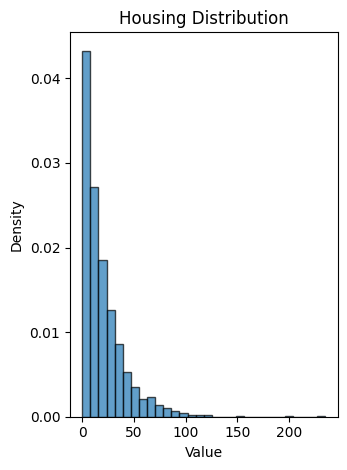

In [58]:
def gen_data(n, y_min, alpha, mu, c, seed=1):

  # Validate parameters
    if y_min <= c:
        raise ValueError
    if alpha <= 1:
        raise ValueError
    if mu <= 0:
        raise ValueError

    U = np.random.uniform(size=n)
    y = y_min * (1 - U) ** (-1.0 / alpha)

    U_exp = np.random.uniform(size=n)
    d = -mu * np.log(U_exp)

    y = np.sort(y)
    d = np.sort(d)
    return y, d


# Generate samples for visualization
n = 2000
y_min = 80
alpha = 1.75
mu = 1/10
c = 50
seed = 1

y_samples, d_samples = gen_data(n, y_min, alpha, mu, c, 1)
print(f'Income: {y_samples}')
print(f'Housing Distance: {d_samples}')

# PLOT DISTRIBUTIONS

plt.figure(figsize=(12, 6))

# INCOME
plt.subplot(1, 2, 1)
plt.hist(y_samples, bins=30, density=True, alpha=0.7, edgecolor="black")
plt.title("Income Distribution")
plt.xlabel("Value")
plt.ylabel("Density")


# HOUSING
plt.subplot(1, 2, 2)
plt.hist(d_samples, bins=30, density=True, alpha=0.7, edgecolor="black")
plt.title("Housing Distribution")
plt.xlabel("Value")
plt.ylabel("Density")

plt.tight_layout()
plt.show()

n = 2000
y_min = 80
alpha = 1.75
mu = 20
c = 10
seed = 1

y_samples, d_samples = gen_data(n, y_min, alpha, mu, c, 1)
print(f'Income: {y_samples}')
print(f'Housing Distance: {d_samples}')


# HOUSING
plt.subplot(1, 2, 2)
plt.hist(d_samples, bins=30, density=True, alpha=0.7, edgecolor="black")
plt.title("Housing Distribution")
plt.xlabel("Value")
plt.ylabel("Density")

plt.tight_layout()
plt.show()


## Visualization and Statistics

In [47]:
def compute_statistics(prices):
    average = np.mean(prices)
    median = np.median(prices)
    Q1 = np.percentile(prices, 25)
    Q3 = np.percentile(prices, 75)
    IQR = Q3 - Q1

    statistics = {
        'average': average,
        'median': median,
        'Q1' : Q1,
        'Q3' : Q3,
        'IQR': IQR
    }

    return statistics


def plot_house_prices(y, prices):
    n = len(y)
    income_quantiles = np.linspace(0, 1, n)

    plt.figure(figsize=(12, 6))
    plt.scatter(income_quantiles, prices, s=10, alpha=0.5, color='b')
    plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
    plt.ylabel('House Price')
    plt.title('House Prices vs. Income Quantile')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_percentage_income_spent(y, prices):
    n = len(y)
    income_quantiles = np.linspace(0, 1, n)
    with np.errstate(divide='ignore', invalid='ignore'):
        percentage_spent = np.where(y != 0, (prices / y) * 100, 0)

    plt.figure(figsize=(10, 6))
    plt.plot(income_quantiles, percentage_spent, marker='s', linestyle='--', color='r')
    plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
    plt.ylabel('Percentage of Income Spent on Housing (%)')
    plt.title('Percentage of Income Spent on Housing vs. Income Quantile')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#plot_house_prices(y, prices)
#plot_percentage_income_spent(y, prices)
#print(compute_statistics(prices))

## 2a

In [61]:
def equilibrium_price_recursive(n, c, y, d, j):

    if j < 0 or j >= n:
        raise ValueError(f"Invalid j: {j}. It should be between 0 and {n-1}.")

    if j == 0:
        return c  # Base case: first house price is equal to c

    theta_j = np.exp(-(d[j] - d[j - 1]))
    # Recursive call for the previous house (j-1)
    previous_price = equilibrium_price_recursive(n, c, y, d, j - 1)
    equilibrium_price = theta_j * previous_price + (1 - theta_j) * y[j]
    return equilibrium_price

def calc_all_prices(n, c, y, d):
    prices = []
    for j in range(n):
        prices.append(equilibrium_price_recursive(n, c, y, d, j))
    return np.array(prices)


In [49]:
def calc_prices_iterative(n, c, y, d):
    prices = np.zeros(n)
    prices[0] = c  # Base case
    
    # Calculate prices iteratively
    for j in range(1, n):
        theta_j = np.exp(-(d[j] - d[j-1]))
        prices[j] = theta_j * prices[j-1] + (1 - theta_j) * y[j]
    
    return prices


In [66]:
import numpy as np

def memo_price_recursive(n, c, y, d, j, memo=None):
    # Initialize memo array if not provided
    if memo is None:
        memo = np.full(n, np.nan)
    
    # Input validation
    if j < 0 or j >= n:
        raise ValueError(f"Invalid j: {j}. It should be between 0 and {n-1}.")
    
    # Check if value is already memoized
    if not np.isnan(memo[j]):
        return memo[j]
    
    # Base case: first house price
    if j == 0:
        memo[0] = c
        return c
    
    # Calculate theta_j
    theta_j = np.exp(-(d[j] - d[j - 1]))
    
    # Recursive call for previous house with memoization
    previous_price = memo_price_recursive(n, c, y, d, j - 1, memo)
    
    # Calculate and memoize current price
    equilibrium_price = theta_j * previous_price + (1 - theta_j) * y[j]
    memo[j] = equilibrium_price
    
    return equilibrium_price

def memo_all_prices(n, c, y, d):
    # Initialize memo array for the entire calculation
    memo = np.full(n, np.nan)
    prices = []
    for j in range(n):
        prices.append(memo_price_recursive(n, c, y, d, j, memo))
    return np.array(prices)

## 4a

### i, ii, iii

   y_min     average      median          Q1          Q3         IQR
0     80  171.654407  110.936973   87.675371  170.071939   82.396568
1    100  202.958164  139.968537  109.856881  208.897415   99.040534
2    150  329.350801  211.240129  164.389296  308.052802  143.663506
   y_min     average      median          Q1          Q3         IQR
0     80  171.654407  110.936973   87.675371  170.071939   82.396568
1    100  202.958164  139.968537  109.856881  208.897415   99.040534
2    150  329.350801  211.240129  164.389296  308.052802  143.663506
   y_min     average      median          Q1          Q3         IQR
0     80  171.654407  110.936973   87.675371  170.071939   82.396568
1    100  202.958164  139.968537  109.856881  208.897415   99.040534
2    150  329.350801  211.240129  164.389296  308.052802  143.663506


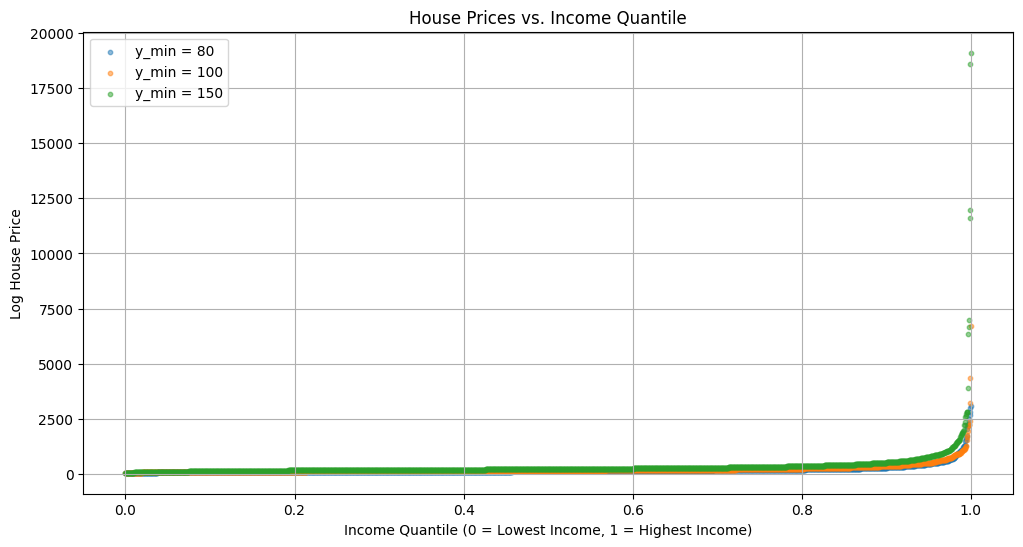

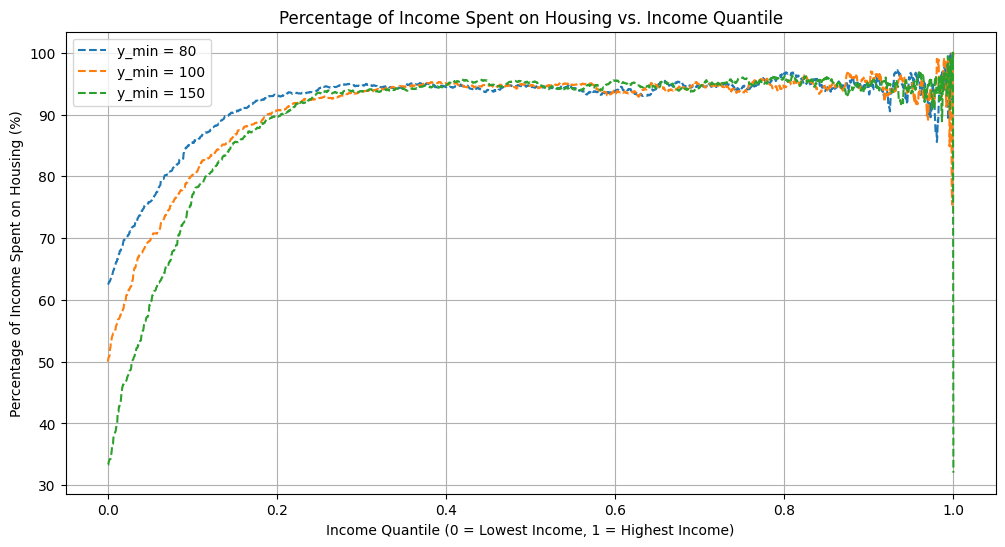

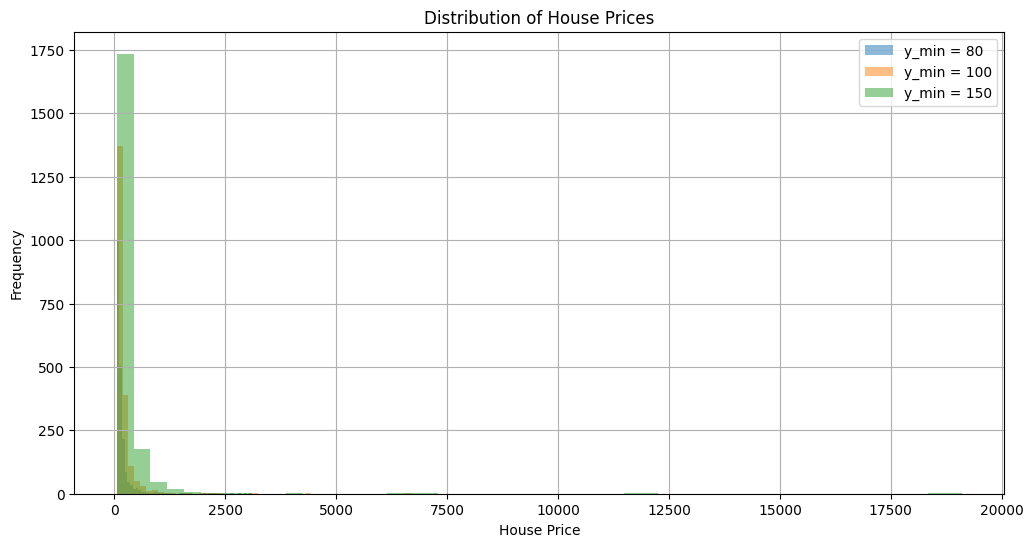

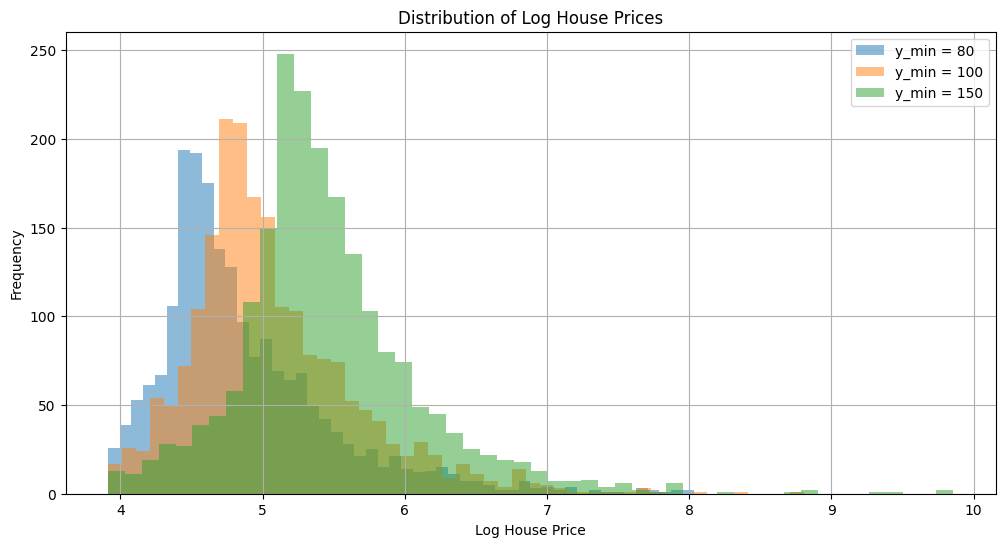

In [68]:
n = 2000
y_min_list = [80, 100, 150]
alpha = 1.75
mu = 10
c = 50
seed = 1
# Initialize lists to collect statistics and data
stats_list = []
stats_list_i = []
stats_list_m = []
all_y = []  # Store income data
all_y_i = []
all_i_prices = []
all_prices = []  # Store price data
all__m = []
all_m_prices = []
all_y_m = []

# Iterate over each y_min value
for y_min in y_min_list:
    # Generate data
    y, d = gen_data(n, y_min, alpha, mu, c)
    
    # Calculate equilibrium prices
    prices_recursive = calc_all_prices(n, c, y, d)
   
    
    # Store the data
    all_y.append(y)
    all_prices.append(prices_recursive)
    
    # Compute statistics
    stats = compute_statistics(prices_recursive)
    stats['y_min'] = y_min  
    stats_list.append(stats)
    
    prices_iterative = calc_prices_iterative(n, c, y, d)
    all_y_i.append(y)
    all_i_prices.append(prices_iterative)
    
    # Compute statistics
    stats_i = compute_statistics(prices_iterative)
    stats_i['y_min'] = y_min  
    stats_list_i.append(stats)


    prices_memo = memo_all_prices(n, c, y, d)
    all_y_m.append(y)
    all_m_prices.append(prices_memo)
    
    # Compute statistics
    stats_i = compute_statistics(prices_memo)
    stats_i['y_min'] = y_min  
    stats_list_m.append(stats)

    # Test base case
   # base_case_price = prices[0]  # This is the price of house j=1
   # if base_case_price == c:
   #     base_case_result = f"Base Case check passed: {base_case_price}"
  #  else:
   #     base_case_result = f"Base Case check failed: {base_case_price}"

stats_df = pd.DataFrame(stats_list)
stats_df = stats_df[['y_min', 'average', 'median', 'Q1', 'Q3', 'IQR']]
print(stats_df)

stats_i_df = pd.DataFrame(stats_list_i)
stats_i_df = stats_i_df[['y_min', 'average', 'median', 'Q1', 'Q3', 'IQR']]
print(stats_i_df)

stats_m_df = pd.DataFrame(stats_list_i)
stats_m_df = stats_m_df[['y_min', 'average', 'median', 'Q1', 'Q3', 'IQR']]
print(stats_m_df)

# Create plots after the loop
income_quantiles = np.linspace(0, 1, n)

# First plot: House Prices vs Income Quantile
plt.figure(figsize=(12, 6))
for i, (prices, y_min) in enumerate(zip(all_prices, y_min_list)):
    plt.scatter(income_quantiles, prices, s=10, alpha=0.5, label=f'y_min = {y_min}')

plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
plt.ylabel('Log House Price')
plt.title('House Prices vs. Income Quantile')
plt.grid(True)
plt.legend()
plt.show()

# Second plot: Percentage of Income Spent
plt.figure(figsize=(12, 6))
for i, (y, prices, y_min) in enumerate(zip(all_y, all_prices, y_min_list)):
    percentage_spent = np.where(y != 0, (prices / y) * 100, 0)
    plt.plot(income_quantiles, percentage_spent, linestyle='--', label=f'y_min = {y_min}')

plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
plt.ylabel('Percentage of Income Spent on Housing (%)')
plt.title('Percentage of Income Spent on Housing vs. Income Quantile')
plt.grid(True)
plt.legend()
plt.show()


plt.figure(figsize=(12, 6))
for i, (prices, y_min) in enumerate(zip(all_prices, y_min_list)):
    plt.hist(prices, bins=50, alpha=0.5, label=f'y_min = {y_min}')

plt.xlabel('House Price')
plt.ylabel('Frequency')
plt.title('Distribution of House Prices')
plt.grid(True)
plt.legend()
plt.show()


plt.figure(figsize=(12, 6))
for i, (prices, y_min) in enumerate(zip(all_prices, y_min_list)):
    plt.hist(np.log(prices), bins=50, alpha=0.5, label=f'y_min = {y_min}')

plt.xlabel('Log House Price')
plt.ylabel('Frequency')
plt.title('Distribution of Log House Prices')
plt.grid(True)
plt.legend()
plt.show()



   alpha     average      median         Q1          Q3         IQR
0   1.25  398.293509  128.929398  93.641505  228.186137  134.544633
1   1.75  172.470285  114.603297  87.743082  169.395748   81.652666
2   3.00  114.048027   96.687840  83.578510  123.691249   40.112739
   alpha     average      median         Q1          Q3         IQR
0   1.25  398.293509  128.929398  93.641505  228.186137  134.544633
1   1.75  172.470285  114.603297  87.743082  169.395748   81.652666
2   3.00  114.048027   96.687840  83.578510  123.691249   40.112739


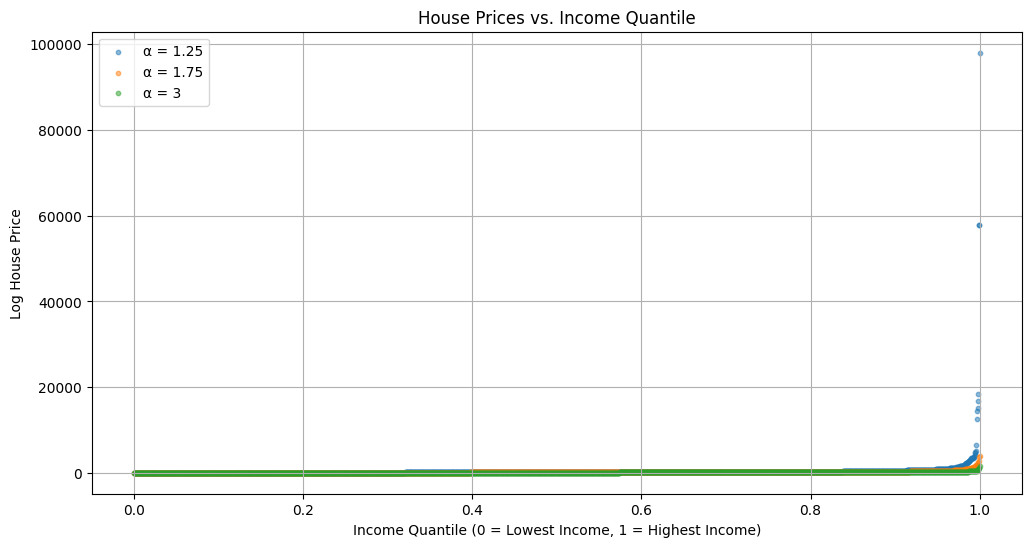

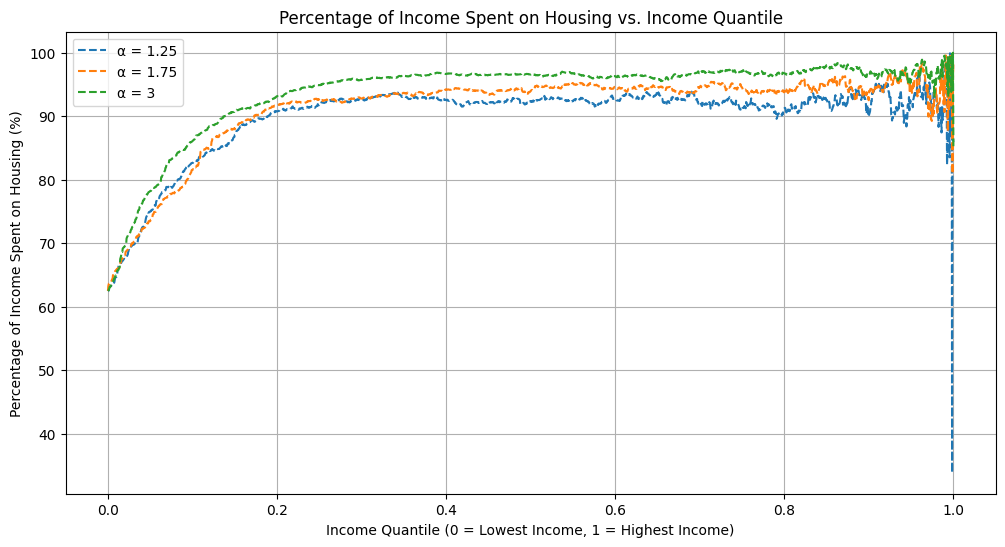

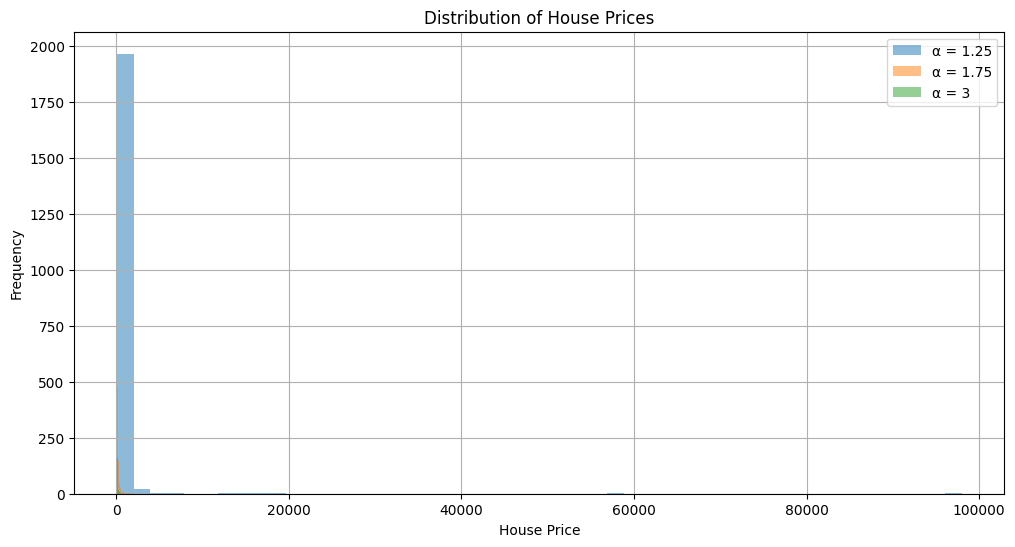

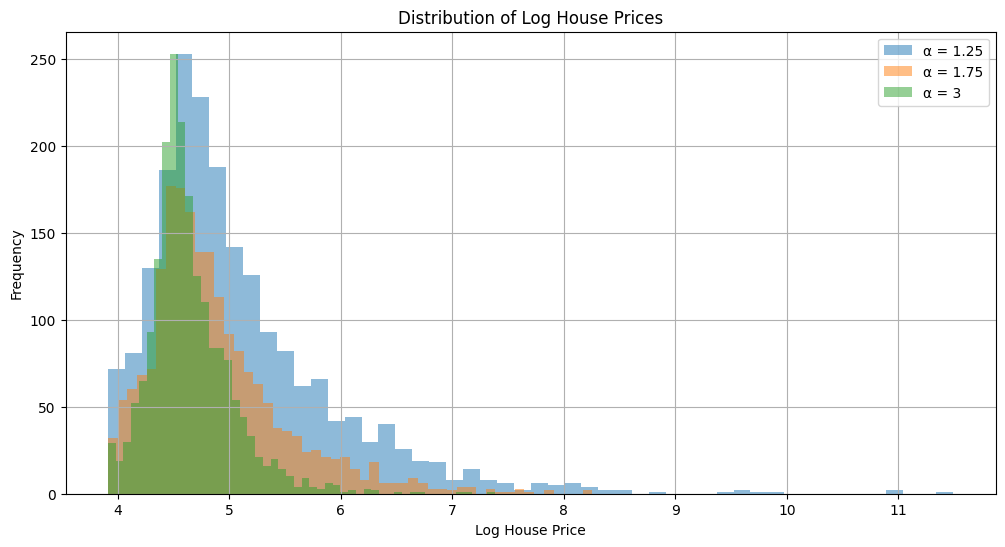

In [ ]:
n = 2000
n_list = [1.25, 1.75, 3]
y_min = 80
mu = 10
c = 50
seed = 1

# Initialize lists to collect statistics and data
stats_list = []
stats_list_i = []
all_y = []  # Store income data
all_y_i = []
all_i_prices = []
all_prices = []  # Store price data

# Iterate over each alpha value
for alpha in n_list:
    # Generate data
    y, d = gen_data(n, y_min, alpha, mu, c)
    
    # Calculate equilibrium prices
    prices_recursive = calc_all_prices(n, c, y, d)
    
    # Store the data
    all_y.append(y)
    all_prices.append(prices_recursive)
    
    # Compute statistics
    stats = compute_statistics(prices_recursive)
    stats['alpha'] = alpha  
    stats_list.append(stats)
    
    prices_iterative = calc_prices_iterative(n, c, y, d)
    all_y_i.append(y)
    all_i_prices.append(prices_iterative)
    
    # Compute statistics
    stats_i = compute_statistics(prices_iterative)
    stats_i['alpha'] = alpha  
    stats_list_i.append(stats_i)  # Fixed: was appending stats instead of stats_i

# Create DataFrames and select columns
stats_df = pd.DataFrame(stats_list)
stats_df = stats_df[['alpha', 'average', 'median', 'Q1', 'Q3', 'IQR']]  # Fixed: Use list for column selection
print(stats_df)

stats_i_df = pd.DataFrame(stats_list_i)
stats_i_df = stats_i_df[['alpha', 'average', 'median', 'Q1', 'Q3', 'IQR']]
print(stats_i_df)

# Create plots after the loop
income_quantiles = np.linspace(0, 1, n)

# First plot: House Prices vs Income Quantile
plt.figure(figsize=(12, 6))
for i, (prices, alpha) in enumerate(zip(all_prices, alpha_list)):
    plt.scatter(income_quantiles, prices, s=10, alpha=0.5, label=f'α = {alpha}')  # Fixed: Label shows alpha instead of y_min
plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
plt.ylabel('Log House Price')
plt.title('House Prices vs. Income Quantile')
plt.grid(True)
plt.legend()
plt.show()

# Second plot: Percentage of Income Spent
plt.figure(figsize=(12, 6))
for i, (y, prices, alpha) in enumerate(zip(all_y, all_prices, alpha_list)):
    percentage_spent = np.where(y != 0, (prices / y) * 100, 0)
    plt.plot(income_quantiles, percentage_spent, linestyle='--', label=f'α = {alpha}')  # Fixed: Label shows alpha
plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
plt.ylabel('Percentage of Income Spent on Housing (%)')
plt.title('Percentage of Income Spent on Housing vs. Income Quantile')
plt.grid(True)
plt.legend()
plt.show()

# Third plot: Distribution of House Prices
plt.figure(figsize=(12, 6))
for i, (prices, alpha) in enumerate(zip(all_prices, alpha_list)):
    plt.hist(prices, bins=50, alpha=0.5, label=f'α = {alpha}')  # Fixed: Label shows alpha
plt.xlabel('House Price')
plt.ylabel('Frequency')
plt.title('Distribution of House Prices')
plt.grid(True)
plt.legend()
plt.show()

# Fourth plot: Distribution of Log House Prices
plt.figure(figsize=(12, 6))
for i, (prices, alpha) in enumerate(zip(all_prices, alpha_list)):
    plt.hist(np.log(prices), bins=50, alpha=0.5, label=f'α = {alpha}')  # Fixed: Label shows alpha
plt.xlabel('Log House Price')
plt.ylabel('Frequency')
plt.title('Distribution of Log House Prices')
plt.grid(True)
plt.legend()
plt.show()

   mu     average      median         Q1          Q3        IQR
0   5  250.068214  107.416426  78.601886  160.720008  82.118121
1  10  177.411062  112.597536  88.466425  166.851880  78.385455
2  20  166.770144  114.374753  91.803213  165.948381  74.145168
   mu     average      median         Q1          Q3        IQR
0   5  250.068214  107.416426  78.601886  160.720008  82.118121
1  10  177.411062  112.597536  88.466425  166.851880  78.385455
2  20  166.770144  114.374753  91.803213  165.948381  74.145168


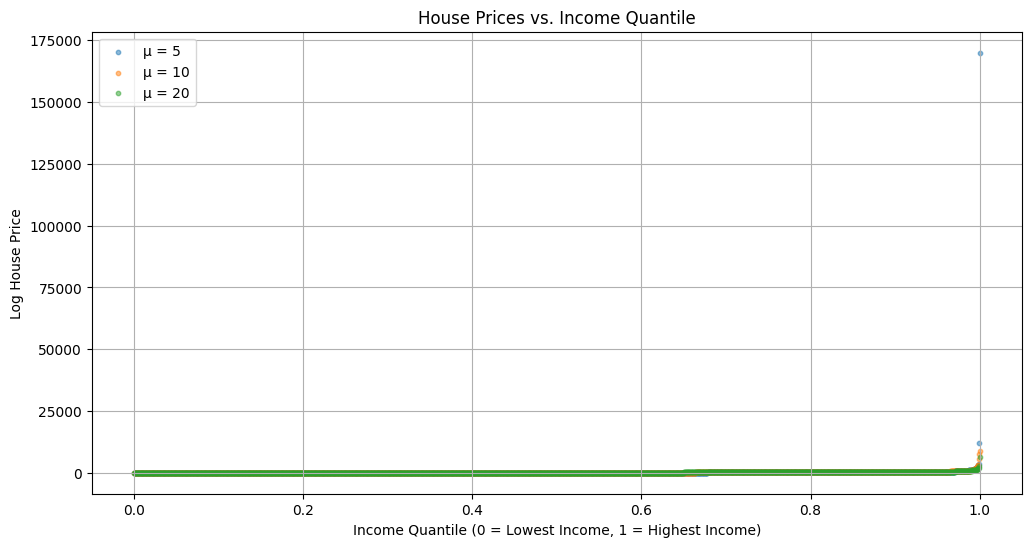

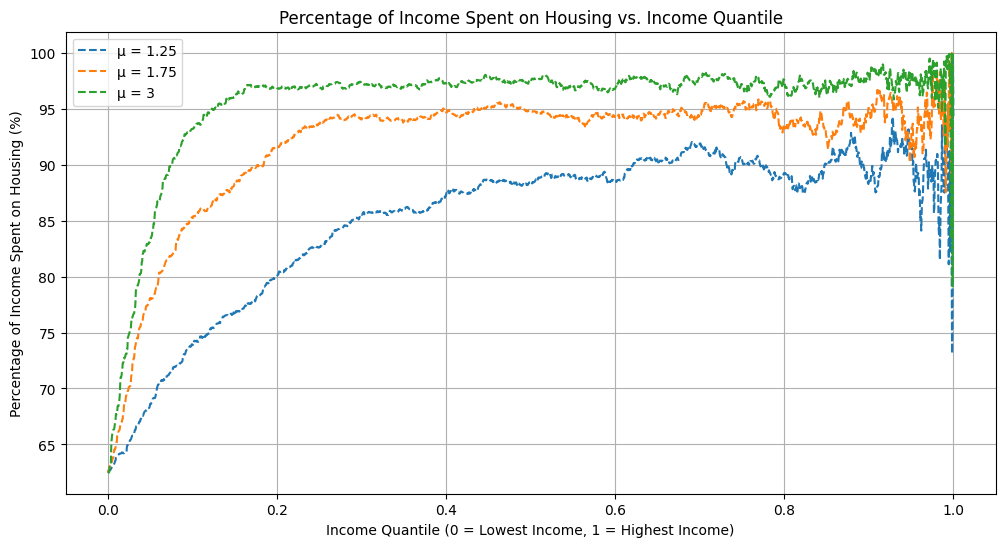

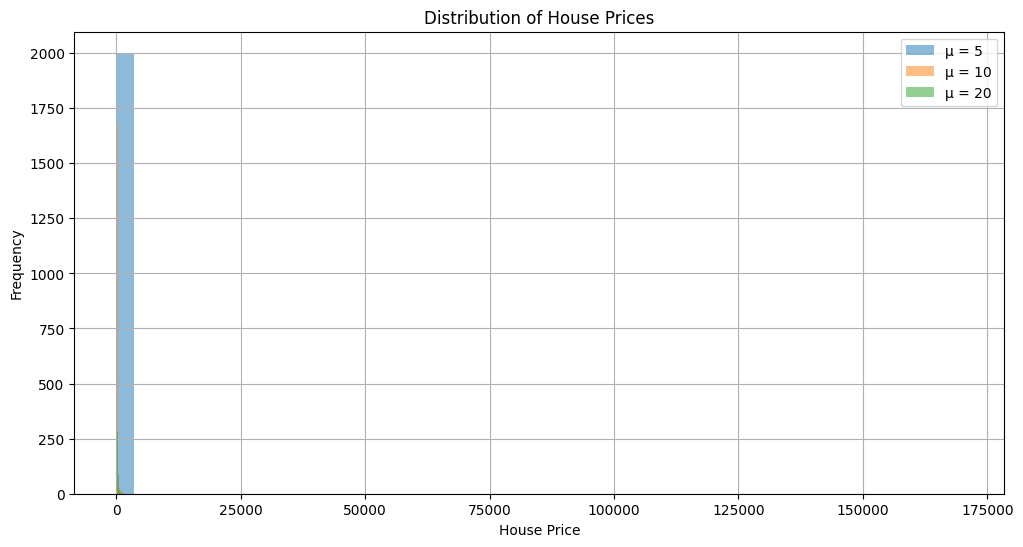

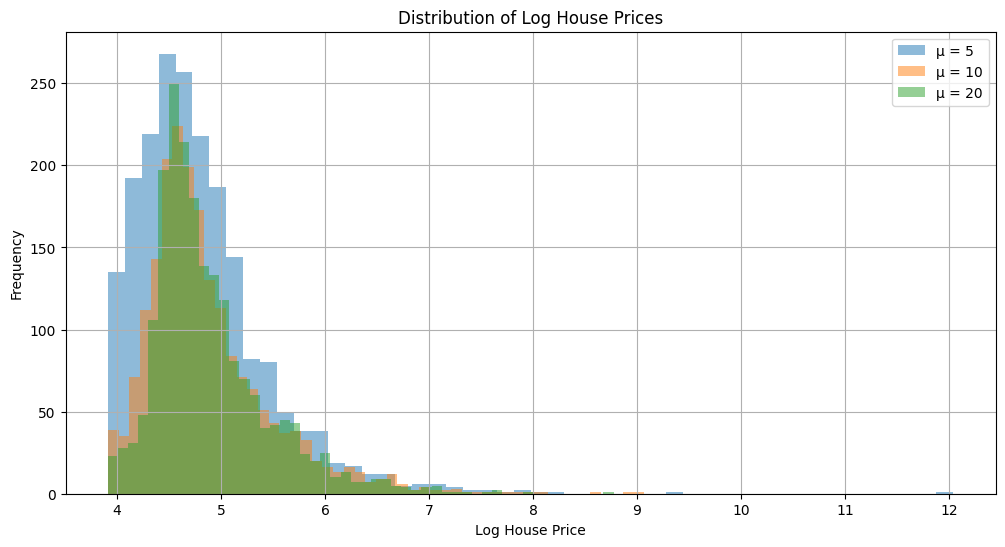

In [ ]:
n = 2000
mu_list = [5,10,20]
y_min = 80
alpha = 1.75
c = 50
seed = 1

# Initialize lists to collect statistics and data
stats_list = []
stats_list_i = []
all_y = []  # Store income data
all_y_i = []
all_i_prices = []
all_prices = []  # Store price data

# Iterate over each alpha value
for mu in mu_list:
    # Generate data
    y, d = gen_data(n, y_min, alpha, mu, c)
    
    # Calculate equilibrium prices
    prices_recursive = calc_all_prices(n, c, y, d)
    
    # Store the data
    all_y.append(y)
    all_prices.append(prices_recursive)
    
    # Compute statistics
    stats = compute_statistics(prices_recursive)
    stats['mu'] = mu  
    stats_list.append(stats)
    
    prices_iterative = calc_prices_iterative(n, c, y, d)
    all_y_i.append(y)
    all_i_prices.append(prices_iterative)
    
    # Compute statistics
    stats_i = compute_statistics(prices_iterative)
    stats_i['mu'] = mu  
    stats_list_i.append(stats_i)  # Fixed: was appending stats instead of stats_i

# Create DataFrames and select columns
stats_df = pd.DataFrame(stats_list)
stats_df = stats_df[['mu', 'average', 'median', 'Q1', 'Q3', 'IQR']]  # Fixed: Use list for column selection
print(stats_df)

stats_i_df = pd.DataFrame(stats_list_i)
stats_i_df = stats_i_df[['mu', 'average', 'median', 'Q1', 'Q3', 'IQR']]
print(stats_i_df)

# Create plots after the loop
income_quantiles = np.linspace(0, 1, n)

# First plot: House Prices vs Income Quantile
plt.figure(figsize=(12, 6))
for i, (prices, mu) in enumerate(zip(all_prices, mu_list)):
    plt.scatter(income_quantiles, prices, s=10, alpha=0.5, label=f'μ = {mu}')  # Fixed: Label shows alpha instead of y_min
plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
plt.ylabel('Log House Price')
plt.title('House Prices vs. Income Quantile')
plt.grid(True)
plt.legend()
plt.show()

# Second plot: Percentage of Income Spent
plt.figure(figsize=(12, 6))
for i, (y, prices, mu) in enumerate(zip(all_y, all_prices, mu_list)):
    percentage_spent = np.where(y != 0, (prices / y) * 100, 0)
    plt.plot(income_quantiles, percentage_spent, linestyle='--', label=f'μ = {mu}')  # Fixed: Label shows alpha
plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
plt.ylabel('Percentage of Income Spent on Housing (%)')
plt.title('Percentage of Income Spent on Housing vs. Income Quantile')
plt.grid(True)
plt.legend()
plt.show()

# Third plot: Distribution of House Prices
plt.figure(figsize=(12, 6))
for i, (prices, mu) in enumerate(zip(all_prices, mu_list)):
    plt.hist(prices, bins=50, alpha=0.5, label=f'μ = {mu}')  # Fixed: Label shows alpha
plt.xlabel('House Price')
plt.ylabel('Frequency')
plt.title('Distribution of House Prices')
plt.grid(True)
plt.legend()
plt.show()

# Fourth plot: Distribution of Log House Prices
plt.figure(figsize=(12, 6))
for i, (prices, mu) in enumerate(zip(all_prices, mu_list)):
    plt.hist(np.log(prices), bins=50, alpha=0.5, label=f'μ = {mu}')  # Fixed: Label shows alpha
plt.xlabel('Log House Price')
plt.ylabel('Frequency')
plt.title('Distribution of Log House Prices')
plt.grid(True)
plt.legend()
plt.show()

      n     average      median         Q1          Q3        IQR
0  2000  169.298293  114.389909  88.266242  171.806332  83.540090
1  4000  165.971258  112.193356  87.457703  163.373966  75.916263


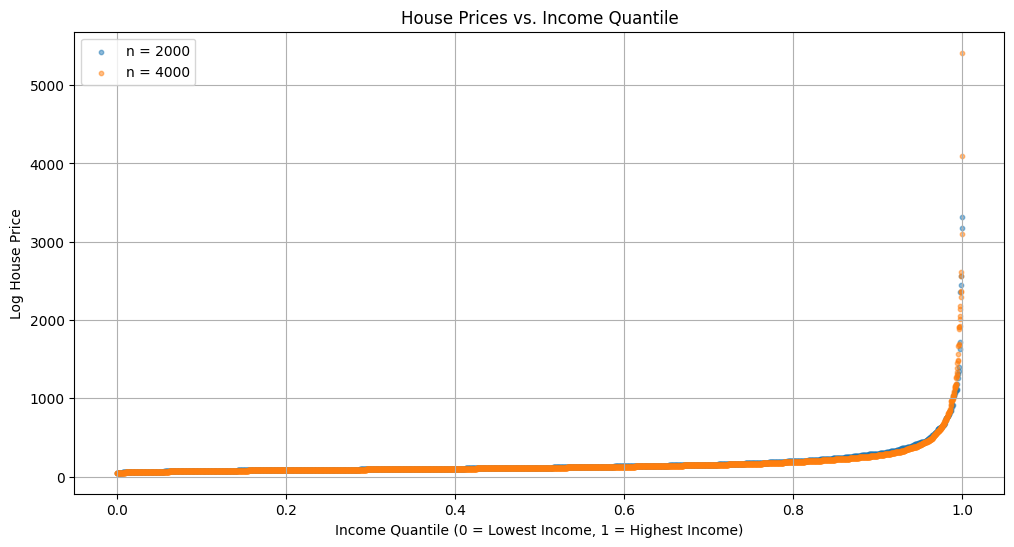

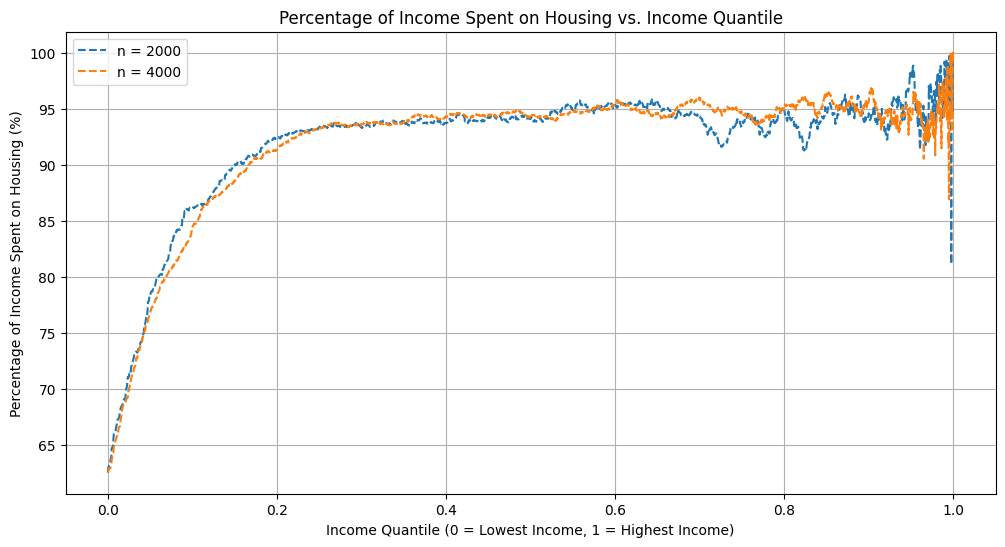

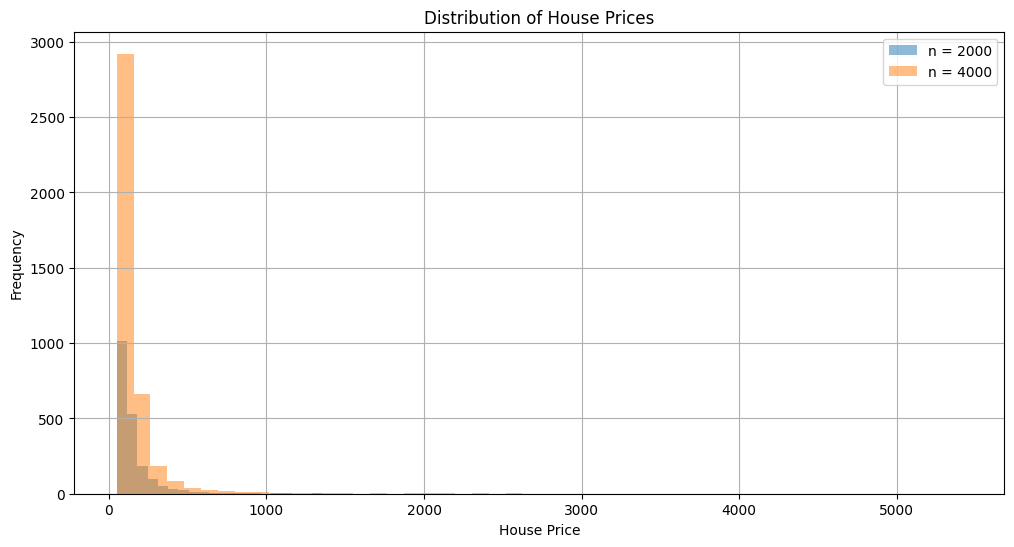

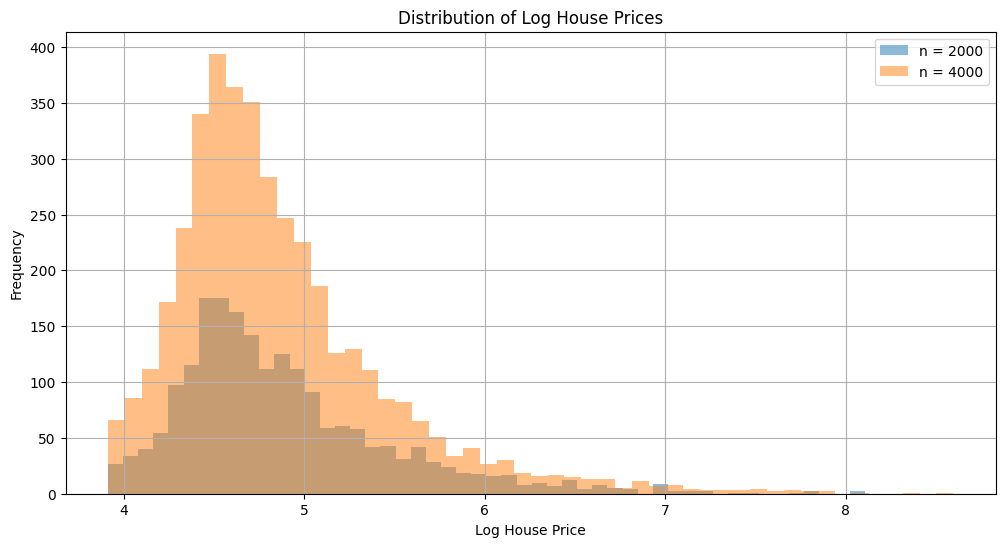

In [76]:
n_list = [2000, 4000]
alpha = 1.75
y_min = 80
mu = 10
c = 50
seed = 1

# Initialize lists to collect statistics and data
stats_list = []
stats_list_i = []
all_y_i = []        # Store income data
all_i_prices = []   # Store iterative price data

# Set random seed for reproducibility
np.random.seed(seed)

# Iterate over each n value
for n in n_list:
    # Generate data
    y, d = gen_data(n, y_min, alpha, mu, c)
    
    # Calculate equilibrium prices iteratively
    prices_iterative = calc_prices_iterative(n, c, y, d)
    all_y_i.append(y)
    all_i_prices.append(prices_iterative)
    
    # Compute statistics
    stats_i = compute_statistics(prices_iterative)
    stats_i['n'] = n  
    stats_list_i.append(stats_i)

# Create a DataFrame for statistics
stats_i_df = pd.DataFrame(stats_list_i)
stats_i_df = stats_i_df[['n', 'average', 'median', 'Q1', 'Q3', 'IQR']]
print(stats_i_df)

# Create plots after the loop

# First Plot: House Prices vs Income Quantile
plt.figure(figsize=(12, 6))
for prices, n in zip(all_i_prices, n_list):
    income_quantiles = np.linspace(0, 1, len(prices))
    plt.scatter(income_quantiles, prices, s=10, alpha=0.5, label=f'n = {n}')
plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
plt.ylabel('Log House Price')
plt.title('House Prices vs. Income Quantile')
plt.grid(True)
plt.legend()
plt.show()

# Second Plot: Percentage of Income Spent
plt.figure(figsize=(12, 6))
for y, prices, n in zip(all_y_i, all_i_prices, n_list):
    income_quantiles = np.linspace(0, 1, len(prices))
    percentage_spent = np.where(y != 0, (prices / y) * 100, 0)
    plt.plot(income_quantiles, percentage_spent, linestyle='--', label=f'n = {n}')
plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
plt.ylabel('Percentage of Income Spent on Housing (%)')
plt.title('Percentage of Income Spent on Housing vs. Income Quantile')
plt.grid(True)
plt.legend()
plt.show()

# Third Plot: Distribution of House Prices
plt.figure(figsize=(12, 6))
for prices, n in zip(all_i_prices, n_list):
    plt.hist(prices, bins=50, alpha=0.5, label=f'n = {n}')
plt.xlabel('House Price')
plt.ylabel('Frequency')
plt.title('Distribution of House Prices')
plt.grid(True)
plt.legend()
plt.show()

# Fourth Plot: Distribution of Log House Prices
plt.figure(figsize=(12, 6))
for prices, n in zip(all_i_prices, n_list):
    plt.hist(np.log(prices), bins=50, alpha=0.5, label=f'n = {n}')
plt.xlabel('Log House Price')
plt.ylabel('Frequency')
plt.title('Distribution of Log House Prices')
plt.grid(True)
plt.legend()
plt.show()

## 2b


## Running DocTest tests

This last step gets the DocTest system to check test cases in the documentation comments.
In this course, you won't need to modify the stuff below, or even understand the details.

In [54]:
import doctest
result = doctest.testmod(verbose=False)
if result[0] == 0:
    print(("Congratulations! You have passed all "+str(result[1])+" tests"))
else:
    print("Rats!")

Congratulations! You have passed all 0 tests
